# MLP2 Data Preprocessing and Exploratory Data Analysis
## Authors: Mia Rodgers and Alex Larsen

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
# import pool
import librosa
from os import listdir, path
from scipy import stats
from os.path import isfile, join
from pathlib import Path
from matplotlib import pyplot as plt
from pandarallel import pandarallel
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## GTZAN Dataset

used this link to get all filenames 
https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

In [3]:
genre_folder = '../rawdata/genres' 
genre_names = [f for f in listdir(path=genre_folder) if not isfile(join(genre_folder, f))] 

creating dict of genres and one random song in the file (for some reason `listdir(...)[0]` does not give the first file)

In [4]:
song_list = []
for g in genre_names:
    p = genre_folder + '/' + g # path for a genre folder
    for song in sorted(listdir(path=p)): # song at index 0 for each folder
        song_path = p+'/'+song
        time_series, sample_rate = librosa.load(Path(song_path))
        song_list.append([song_path, time_series, sample_rate, g])
        

In [5]:
song_df = pd.DataFrame(song_list, columns=['song_file', 'time_series', 'sample_rate', 'genre'])
song_df

,song_file,time_series,sample_rate,genre
0,../rawdata/genres/pop/pop.00000.wav,"[-0.0887146, -0.09524536, -0.102752686, -0.113...",22050,pop
1,../rawdata/genres/pop/pop.00001.wav,"[0.7692261, 0.2246399, 0.69036865, 0.7468872, ...",22050,pop
2,../rawdata/genres/pop/pop.00002.wav,"[-0.09274292, -0.11630249, -0.11886597, -0.107...",22050,pop
3,../rawdata/genres/pop/pop.00003.wav,"[-0.024993896, -0.018157959, -0.020233154, 0.0...",22050,pop
4,../rawdata/genres/pop/pop.00004.wav,"[-0.12844849, -0.10952759, -0.06726074, -0.028...",22050,pop
...,...,...,...,...
995,../rawdata/genres/jazz/jazz.00095.wav,"[-0.062194824, -0.09188843, -0.072052, -0.0799...",22050,jazz
996,../rawdata/genres/jazz/jazz.00096.wav,"[0.045013428, 0.07720947, 0.058258057, 0.06036...",22050,jazz
997,../rawdata/genres/jazz/jazz.00097.wav,"[0.02279663, 0.03564453, 0.029205322, 0.029632...",22050,jazz
998,../rawdata/genres/jazz/jazz.00098.wav,"[-0.031066895, -0.05078125, -0.04537964, -0.04...",22050,jazz


### Feature Extraction

Features to extract:
- BPM
- Zero-Crossing Rate (rate of sign changes from positive to negative)
- Spectral Centroid (weighted mean of frequencies present in the song)
- Spectral Rolloff (measures of shape of the signal, models human voice characteristics)
- Mel-Frequency Cepstral Coefficients (measures shape of spectral envelope)
- Chroma Frequencies (measure of frequencies of different pitches, separated into 12 bins)
- Intensity: loudness in dB (relative to max possible loudness)

In [6]:
# Extract the bpm
song_df['bpm'] = song_df['time_series'].parallel_apply(lambda x: librosa.beat.tempo(y=x)[0])

# Extract the zero crossing rate
song_df['zero_crossing_rate'] = song_df['time_series'].parallel_apply(lambda x: librosa.feature.zero_crossing_rate(y= x)[0])

# Extract the spectral centroid
song_df['spectral_centroid'] = song_df['time_series'].parallel_apply(lambda x: librosa.feature.spectral_centroid(y= x)[0])

# Extract the spectral rolloff
song_df['spectral_rolloff'] = song_df['time_series'].parallel_apply(lambda x: librosa.feature.spectral_rolloff(y= x)[0])

# Extract the mel-frequency cepstral coefficients
song_df['mfcc'] = song_df['time_series'].parallel_apply(lambda x: librosa.feature.mfcc(y= x)[0])

# Extract the chroma frequencies
song_df['chroma_frequencies'] = song_df['time_series'].parallel_apply(lambda x: librosa.feature.chroma_stft(y= x)[0])

song_df

,song_file,time_series,sample_rate,genre,bpm,zero_crossing_rate,spectral_centroid,spectral_rolloff,mfcc,chroma_frequencies
0,../rawdata/genres/pop/pop.00000.wav,"[-0.0887146, -0.09524536, -0.102752686, -0.113...",22050,pop,135.999178,"[0.00927734375, 0.0234375, 0.04541015625, 0.05...","[1812.4619528427452, 2913.4550162394453, 2870....","[5415.6005859375, 8247.216796875, 8118.0175781...","[-195.25616, -150.96812, -132.99374, -149.2361...","[1.0, 1.0, 0.5475675, 0.3053872, 0.40021256, 0..."
1,../rawdata/genres/pop/pop.00001.wav,"[0.7692261, 0.2246399, 0.69036865, 0.7468872, ...",22050,pop,107.666016,"[0.02587890625, 0.03173828125, 0.03662109375, ...","[3696.826349368777, 3781.2397094717344, 3663.4...","[8268.75, 8570.21484375, 8828.61328125, 8021.1...","[8.333065, -5.5007806, -77.25962, -142.30276, ...","[0.79645, 0.5512454, 0.47261614, 0.37714073, 0..."
2,../rawdata/genres/pop/pop.00002.wav,"[-0.09274292, -0.11630249, -0.11886597, -0.107...",22050,pop,129.199219,"[0.03076171875, 0.05419921875, 0.0869140625, 0...","[2951.7610867714993, 2998.306335806811, 3043.4...","[8764.013671875, 8925.5126953125, 7913.4521484...","[-171.28282, -156.23244, -45.063564, 26.249937...","[0.29866484, 0.13757597, 0.2682937, 0.5632394,..."
3,../rawdata/genres/pop/pop.00003.wav,"[-0.024993896, -0.018157959, -0.020233154, 0.0...",22050,pop,92.285156,"[0.06689453125, 0.08251953125, 0.0908203125, 0...","[3016.556497593843, 2733.093472180655, 2394.70...","[8914.74609375, 7934.9853515625, 7418.18847656...","[-151.17372, -115.99337, -137.84445, -183.4657...","[1.0, 1.0, 0.35716882, 0.13711457, 0.09756261,..."
4,../rawdata/genres/pop/pop.00004.wav,"[-0.12844849, -0.10952759, -0.06726074, -0.028...",22050,pop,107.666016,"[0.0419921875, 0.0634765625, 0.08447265625, 0....","[1861.496524385576, 1894.3471992720065, 1987.4...","[3348.4130859375, 3348.4130859375, 3359.179687...","[-87.60696, -63.465073, -62.712914, -56.52946,...","[0.3122931, 0.39315093, 0.3674996, 0.2786543, ..."
...,...,...,...,...,...,...,...,...,...,...
995,../rawdata/genres/jazz/jazz.00095.wav,"[-0.062194824, -0.09188843, -0.072052, -0.0799...",22050,jazz,117.453835,"[0.02587890625, 0.03759765625, 0.0556640625, 0...","[1814.6794306123995, 2044.7159649785262, 2234....","[3886.7431640625, 4909.5703125, 5760.131835937...","[-211.30547, -206.57405, -231.43155, -213.8381...","[0.30835617, 0.11353422, 0.09033803, 0.1906156..."
996,../rawdata/genres/jazz/jazz.00096.wav,"[0.045013428, 0.07720947, 0.058258057, 0.06036...",22050,jazz,135.999178,"[0.044921875, 0.0673828125, 0.0859375, 0.09570...","[1955.5418442933342, 2164.7091771559126, 2369....","[4532.7392578125, 5200.2685546875, 5523.266601...","[-181.1916, -177.69016, -204.2336, -220.05225,...","[0.08535859, 0.028048158, 0.0101286825, 0.0071..."
997,../rawdata/genres/jazz/jazz.00097.wav,"[0.02279663, 0.03564453, 0.029205322, 0.029632...",22050,jazz,112.347147,"[0.017578125, 0.0263671875, 0.03564453125, 0.0...","[1187.8249264990166, 952.6527363855892, 817.10...","[2217.919921875, 1442.724609375, 1184.32617187...","[-354.09113, -373.8292, -403.8538, -416.41177,...","[0.04638605, 0.038805343, 0.03744892, 0.031752..."
998,../rawdata/genres/jazz/jazz.00098.wav,"[-0.031066895, -0.05078125, -0.04537964, -0.04...",22050,jazz,161.499023,"[0.0068359375, 0.01611328125, 0.0205078125, 0....","[1456.6106500541023, 1413.8374732896405, 1448....","[3563.7451171875, 3499.1455078125, 3574.511718...","[-308.07678, -300.8568, -313.62973, -321.6552,...","[0.9682443, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974775..."


In [7]:
corr_df = pd.DataFrame()
corr_df['genre'] = song_df['genre']
corr_df['bpm'] = song_df['bpm']
for col in song_df.columns.drop(['song_file', 'time_series', 'sample_rate', 'genre','bpm']):
    corr_df['avg_{0}'.format(col)] = song_df[col].parallel_apply(lambda x: x.mean())

corr_df.head()

,genre,bpm,avg_zero_crossing_rate,avg_spectral_centroid,avg_spectral_rolloff,avg_mfcc,avg_chroma_frequencies
0,pop,135.999178,0.126720,3422.071864,7953.037936,-94.507706,0.383527
1,pop,107.666016,0.149394,3702.062803,8072.969384,-59.167095,0.446750
2,pop,129.199219,0.118866,3214.019678,7424.267068,-59.600990,0.475822
3,pop,92.285156,0.085323,1837.492826,3671.361172,-125.878746,0.373030
4,pop,107.666016,0.123709,2753.234723,5986.838328,-20.932325,0.380148


In [8]:
from scipy import stats


for c in corr_df.columns.drop('genre'):
    F, p = stats.f_oneway(corr_df[corr_df.genre == genre_names[0]][c],
                          corr_df[corr_df.genre == genre_names[1]][c],
                          corr_df[corr_df.genre == genre_names[2]][c],
                          corr_df[corr_df.genre == genre_names[3]][c],
                          corr_df[corr_df.genre == genre_names[4]][c],
                          corr_df[corr_df.genre == genre_names[5]][c],
                          corr_df[corr_df.genre == genre_names[6]][c],
                          corr_df[corr_df.genre == genre_names[7]][c],
                          corr_df[corr_df.genre == genre_names[8]][c],
                          corr_df[corr_df.genre == genre_names[9]][c])
    print(c,F)

bpm 9.509992300744322
avg_zero_crossing_rate 58.716379580769235
avg_spectral_centroid 97.49446582239015
avg_spectral_rolloff 110.888295771945
avg_mfcc 130.37855478076267
avg_chroma_frequencies 35.1655215554282


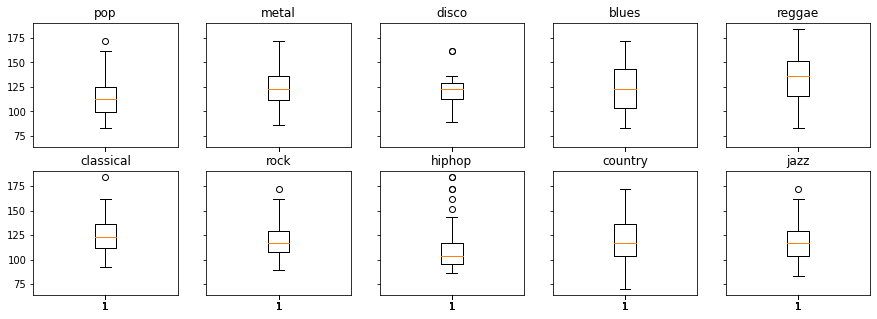

In [9]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=[15, 5])
count = 0

for g in genre_names:
    idx = (int(count/5), count % 5)
    df = song_df[song_df['genre'] == g]
    axs[idx].boxplot(df.bpm)
    axs[idx].set(title=g)
    count = count + 1

plt.show()


In [10]:
# Normalize the data
scaler = MinMaxScaler()

corr_df[['bpm', 'avg_zero_crossing_rate', 'avg_spectral_centroid', 'avg_spectral_rolloff', 'avg_mfcc', 'avg_chroma_frequencies']] = scaler.fit_transform(corr_df[['bpm', 'avg_zero_crossing_rate', 'avg_spectral_centroid', 'avg_spectral_rolloff', 'avg_mfcc', 'avg_chroma_frequencies']])

corr_df.describe()

,bpm,avg_zero_crossing_rate,avg_spectral_centroid,avg_spectral_rolloff,avg_mfcc,avg_chroma_frequencies
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.446653,0.323861,0.422090,0.482098,0.686010,0.455264
std,0.182272,0.165343,0.185212,0.198621,0.168647,0.152026
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.292174,0.191934,0.273598,0.331810,0.591308,0.352188
50%,0.415020,0.307614,0.424016,0.493016,0.726683,0.448626
75%,0.576659,0.435872,0.548713,0.603446,0.804705,0.551128
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


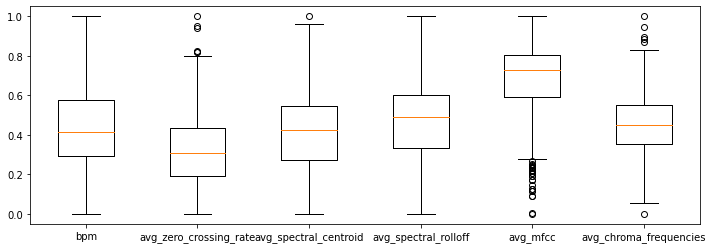

In [11]:
# Make a boxplot
song_cols = corr_df[['bpm', 'avg_zero_crossing_rate', 'avg_spectral_centroid', 'avg_spectral_rolloff', 'avg_mfcc', 'avg_chroma_frequencies']]
plt.figure(figsize=(12,4))
plt.boxplot([song_cols[column] for column in song_cols.columns], labels= [column for column in song_cols.columns])
plt.show()


In [12]:
corr_df

,genre,bpm,avg_zero_crossing_rate,avg_spectral_centroid,avg_spectral_rolloff,avg_mfcc,avg_chroma_frequencies
0,pop,0.576659,0.415220,0.737759,0.908591,0.770132,0.454706
1,pop,0.329710,0.504865,0.810195,0.923718,0.829603,0.540242
2,pop,0.517391,0.384168,0.683935,0.841894,0.828873,0.579575
3,pop,0.195652,0.251552,0.327818,0.368520,0.717341,0.440504
4,pop,0.329710,0.403314,0.564727,0.660583,0.893944,0.450134
...,...,...,...,...,...,...,...
995,jazz,0.415020,0.164729,0.332252,0.445570,0.559296,0.436090
996,jazz,0.576659,0.221480,0.337221,0.411075,0.462587,0.309047
997,jazz,0.370510,0.071998,0.156770,0.201185,0.233205,0.173162
998,jazz,0.798913,0.144046,0.340269,0.455003,0.553913,0.445306


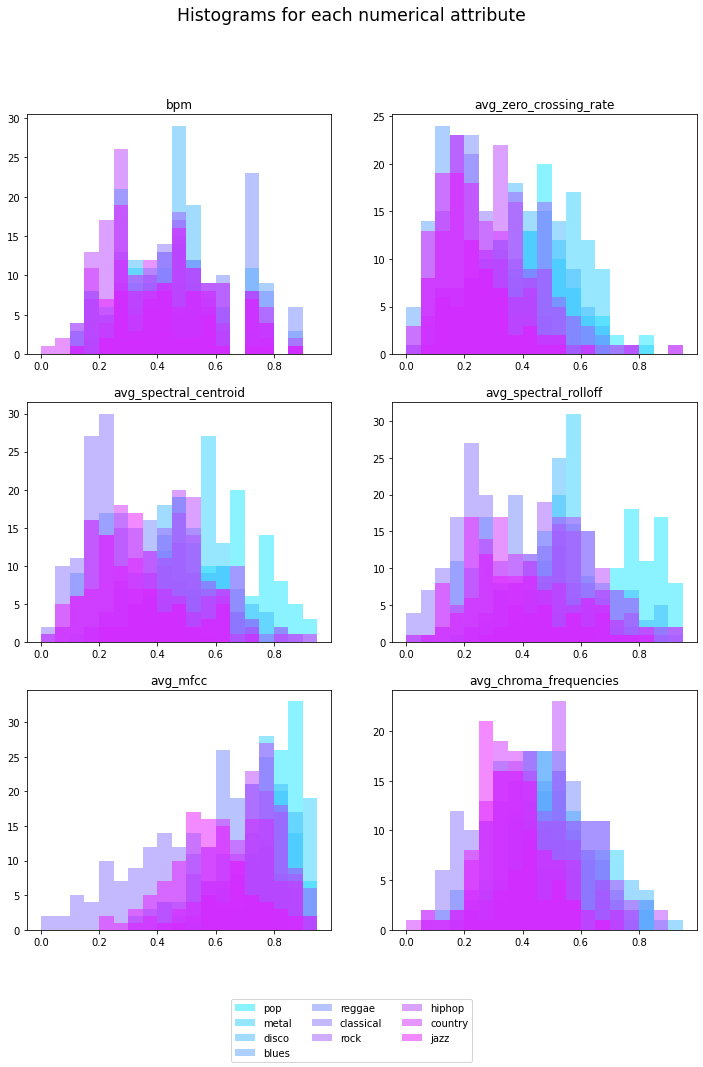

In [13]:
music_genres = corr_df.genre.unique()
numeric = corr_df[['bpm', 'avg_zero_crossing_rate', 'avg_spectral_centroid', 'avg_spectral_rolloff', 'avg_mfcc', 'avg_chroma_frequencies']]
colors = sns.color_palette('cool',10)
nrows = 2
ncols = 3
fig, axs = plt.subplots(ncols,nrows, figsize = (12, 15))
i = 0
for col in numeric:
    idx = (int(i/nrows), i%nrows)
    min = corr_df[col].min()
    max = corr_df[col].max()
    diff = max-min
    binw = [x*diff/20+min for x in range(20)]
    img = [
        axs[idx].hist(x=corr_df[corr_df['genre'] == music_genres[i]][col], 
        bins=binw, alpha=0.5, histtype='bar', 
        color = colors[i])
     for i in range(len(music_genres))]
    axs[idx].set(title = col)
    i += 1
fig.legend(labels=[corr_df[corr_df['genre'] == music_genres[i]]['genre'].iloc[0] for i in range(len(music_genres))], ncol=3, loc = 8, fontsize = 'medium', frameon=True, borderaxespad=0.5)
fig.suptitle('Histograms for each numerical attribute',size='xx-large')
plt.show()

[Text(0.5, 0, 'bpm'),
 Text(1.5, 0, 'avg_zero_crossing_rate'),
 Text(2.5, 0, 'avg_spectral_centroid'),
 Text(3.5, 0, 'avg_spectral_rolloff'),
 Text(4.5, 0, 'avg_mfcc'),
 Text(5.5, 0, 'avg_chroma_frequencies')]

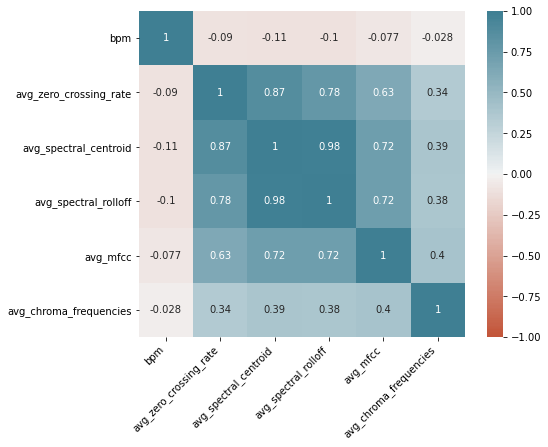

In [14]:
np.random.seed(1)

# Compute the correlation matrix
corr = corr_df.corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(60, 200, n=200),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [15]:
cs = corr_df.columns.drop(['genre'])
corrs = {}
for c in cs:
    F, p = stats.f_oneway(corr_df[corr_df.genre == music_genres[0]][c],
                          corr_df[corr_df.genre == music_genres[1]][c],
                          corr_df[corr_df.genre == music_genres[2]][c],
                          corr_df[corr_df.genre == music_genres[3]][c],
                          corr_df[corr_df.genre == music_genres[4]][c],
                          corr_df[corr_df.genre == music_genres[5]][c],
                          corr_df[corr_df.genre == music_genres[6]][c],
                          corr_df[corr_df.genre == music_genres[7]][c],
                          corr_df[corr_df.genre == music_genres[8]][c],
                          corr_df[corr_df.genre == music_genres[9]][c])
    corrs[c] = F

# The greater the F score value the higher the correlation will be.
sorted_corrs = dict(
    sorted(corrs.items(), key=lambda item: item[1], reverse=True))

print('Correlation with genre:')
for key, val in sorted_corrs.items():
    print(key, val)


Correlation with genre:
avg_mfcc 130.3785547807627
avg_spectral_rolloff 110.88829577194502
avg_spectral_centroid 97.4944658223901
avg_zero_crossing_rate 58.71637958076927
avg_chroma_frequencies 35.16552155542821
bpm 9.509992300744331


In [86]:
# Create a csv file containing the preprocessed data
song_df.to_csv('../input/audio_data.csv', index = False)
corr_df.to_csv('../input/audio_means.csv', index=False)


## CSV Dataset

### Data Preprocessing

In [4]:
# Load the data
df = pd.read_csv('../rawdata/music_genre.csv')
df.head(5) 


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [5]:
df.tail()


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.0,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.0,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.0,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.0,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop
50004,63470.0,Naughty By Nature,Hip Hop Hooray,67.0,0.10200,0.862,267267.0,0.642,0.0,F#,0.272,-13.652,Minor,0.1010,99.20100000000001,4-Apr,0.765,Hip-Hop


In [6]:
df = df.drop(columns=['obtained_date','instance_id'])


In [7]:
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,0.456264
std,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,0.247119
min,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,0.257000
50%,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,0.448000
75%,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,0.648000
max,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


In [8]:
# Find null data
print(df.isnull().sum())

artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
valence             5
music_genre         5
dtype: int64


In [9]:
# Drop the 5 rows of null data
df.dropna(inplace=True)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       50000 non-null  object 
 1   track_name        50000 non-null  object 
 2   popularity        50000 non-null  float64
 3   acousticness      50000 non-null  float64
 4   danceability      50000 non-null  float64
 5   duration_ms       50000 non-null  float64
 6   energy            50000 non-null  float64
 7   instrumentalness  50000 non-null  float64
 8   key               50000 non-null  object 
 9   liveness          50000 non-null  float64
 10  loudness          50000 non-null  float64
 11  mode              50000 non-null  object 
 12  speechiness       50000 non-null  float64
 13  tempo             50000 non-null  object 
 14  valence           50000 non-null  float64
 15  music_genre       50000 non-null  object 
dtypes: float64(10), object(6)
memory usage: 

In [11]:
# Print tracks with an unknown duration and tempo
df[df['duration_ms'] < 0][[ 'artist_name', 'track_name', 'duration_ms', 'tempo']]


,artist_name,track_name,duration_ms,tempo
0,Röyksopp,Röyksopp's Night Out,-1.0,100.889
13,DJ Shadow,Broken Levee Blues,-1.0,154.745
16,San Holo,One Thing,-1.0,151.756
24,The Prodigy,Diesel Power,-1.0,105.919
35,Fabian Mazur,If U Wanted To,-1.0,?
...,...,...,...,...
49956,empty_field,What You Like (feat. Ty Dolla $ign & Wiz Khalifa),-1.0,140.005
49969,Bone Thugs-N-Harmony,No Surrender,-1.0,85.963
49979,Young Dolph,Thinking Out Loud,-1.0,140.101
49981,Mac Miller,Party On Fifth Ave.,-1.0,97.101


In [13]:
# Mark non-numeric values as missing or NaN
df['duration_ms'] = df['duration_ms'].replace(-1, np.NaN)
df['duration_ms'] = pd.to_numeric(df['duration_ms'], errors='coerce')
# df['tempo'] = df['tempo'].replace('?', np.NaN)
df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')

# We expect an empty dataframe here, as the values have been nulled out
df[df['duration_ms'] < 0][['artist_name', 'track_name', 'duration_ms', 'tempo']].count()

artist_name    0
track_name     0
duration_ms    0
tempo          0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       50000 non-null  object 
 1   track_name        50000 non-null  object 
 2   popularity        50000 non-null  float64
 3   acousticness      50000 non-null  float64
 4   danceability      50000 non-null  float64
 5   duration_ms       45061 non-null  float64
 6   energy            50000 non-null  float64
 7   instrumentalness  50000 non-null  float64
 8   key               50000 non-null  object 
 9   liveness          50000 non-null  float64
 10  loudness          50000 non-null  float64
 11  mode              50000 non-null  object 
 12  speechiness       50000 non-null  float64
 13  tempo             45020 non-null  float64
 14  valence           50000 non-null  float64
 15  music_genre       50000 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [15]:
# Find null data
print(df.isnull().sum())

artist_name            0
track_name             0
popularity             0
acousticness           0
danceability           0
duration_ms         4939
energy                 0
instrumentalness       0
key                    0
liveness               0
loudness               0
mode                   0
speechiness            0
tempo               4980
valence                0
music_genre            0
dtype: int64


We will experiment with 2 options here: dropping rows with missing values, and replacing rows with missing values with the mean.

In [31]:
# Drop rows with missing values
dropped = df.copy()

dropped.dropna(inplace=True)
dropped

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
1,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.124,-7.043,Minor,0.0300,115.002,0.531,Electronic
2,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
3,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic
4,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic
6,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.106,-4.294,Major,0.3510,149.995,0.230,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49999,Night Lovell,Barbie Doll,56.0,0.13300,0.849,237667.0,0.660,0.000008,C,0.296,-7.195,Major,0.0516,99.988,0.629,Hip-Hop
50001,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.000000,B,0.109,-9.814,Major,0.0550,122.043,0.113,Hip-Hop
50002,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.000000,D,0.143,-5.443,Major,0.1460,131.079,0.395,Hip-Hop
50003,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.000000,G,0.106,-5.016,Minor,0.0441,75.886,0.354,Hip-Hop


In [32]:
# Fill missing values with mean columnn values
numeric_columns = ['popularity', 'duration_ms', 'loudness', 'tempo']
mean_filled = df.copy()

for col in numeric_columns:
    mean_filled[col] = mean_filled.groupby('music_genre').transform(
        lambda x: x.fillna(x.mean()))

mean_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       50000 non-null  object 
 1   track_name        50000 non-null  object 
 2   popularity        50000 non-null  float64
 3   acousticness      50000 non-null  float64
 4   danceability      50000 non-null  float64
 5   duration_ms       50000 non-null  float64
 6   energy            50000 non-null  float64
 7   instrumentalness  50000 non-null  float64
 8   key               50000 non-null  object 
 9   liveness          50000 non-null  float64
 10  loudness          50000 non-null  float64
 11  mode              50000 non-null  object 
 12  speechiness       50000 non-null  float64
 13  tempo             50000 non-null  float64
 14  valence           50000 non-null  float64
 15  music_genre       50000 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

### Exploratory Data Analysis

In [33]:
# Get the five-number summary for each field
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,50000.000000,50000.000000,50000.000000,4.506100e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,45020.000000,50000.000000
mean,44.220420,0.306383,0.558241,2.455035e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,119.952961,0.456264
std,15.542008,0.341340,0.178632,1.114333e+05,0.264559,0.325409,0.161637,6.162990,0.101373,30.641701,0.247119
min,0.000000,0.000000,0.059600,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000
25%,34.000000,0.020000,0.442000,1.904670e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,94.941500,0.257000
50%,45.000000,0.144000,0.568000,2.273600e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,119.879000,0.448000
75%,56.000000,0.552000,0.687000,2.756800e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,140.471250,0.648000
max,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000


In [34]:
# Get the five-number summary for each field of dropped
dropped.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,40560.000000,40560.000000,40560.000000,4.056000e+04,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000
mean,44.276677,0.305974,0.558418,2.454895e+05,0.600330,0.181603,0.193820,-9.126369,0.093738,119.874523,0.456921
std,15.545617,0.341108,0.178652,1.101214e+05,0.264501,0.325710,0.161501,6.154679,0.101502,30.653215,0.246942
min,0.000000,0.000000,0.059600,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000
25%,34.000000,0.020000,0.442000,1.904800e+05,0.433000,0.000000,0.097000,-10.843000,0.036100,94.893000,0.259000
50%,45.000000,0.144000,0.569000,2.275330e+05,0.644000,0.000157,0.126000,-7.277000,0.048900,119.755500,0.449000
75%,56.000000,0.550000,0.687000,2.757600e+05,0.817000,0.152000,0.244000,-5.174000,0.098800,140.344000,0.648000
max,99.000000,0.996000,0.986000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000


In [35]:
# Get the five-number summary for each field of mean_filled
mean_filled.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,44.220420,0.306383,0.558241,44.220420,0.599755,0.181601,0.193896,44.220420,0.093586,44.220420,0.456264
std,15.542008,0.341340,0.178632,15.542008,0.264559,0.325409,0.161637,15.542008,0.101373,15.542008,0.247119
min,0.000000,0.000000,0.059600,0.000000,0.000792,0.000000,0.009670,0.000000,0.022300,0.000000,0.000000
25%,34.000000,0.020000,0.442000,34.000000,0.433000,0.000000,0.096900,34.000000,0.036100,34.000000,0.257000
50%,45.000000,0.144000,0.568000,45.000000,0.643000,0.000158,0.126000,45.000000,0.048900,45.000000,0.448000
75%,56.000000,0.552000,0.687000,56.000000,0.815000,0.155000,0.244000,56.000000,0.098525,56.000000,0.648000
max,99.000000,0.996000,0.986000,99.000000,0.999000,0.996000,1.000000,99.000000,0.942000,99.000000,0.992000


In [36]:
mean_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       50000 non-null  object 
 1   track_name        50000 non-null  object 
 2   popularity        50000 non-null  float64
 3   acousticness      50000 non-null  float64
 4   danceability      50000 non-null  float64
 5   duration_ms       50000 non-null  float64
 6   energy            50000 non-null  float64
 7   instrumentalness  50000 non-null  float64
 8   key               50000 non-null  object 
 9   liveness          50000 non-null  float64
 10  loudness          50000 non-null  float64
 11  mode              50000 non-null  object 
 12  speechiness       50000 non-null  float64
 13  tempo             50000 non-null  float64
 14  valence           50000 non-null  float64
 15  music_genre       50000 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

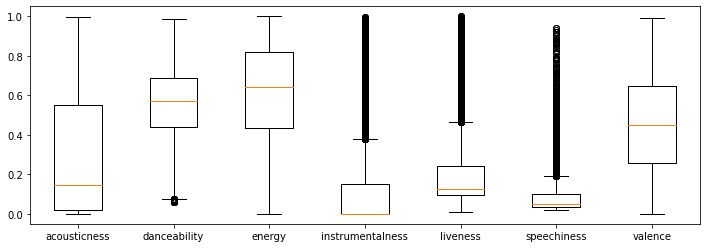

In [37]:
# Make a boxplot
cols = dropped[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']]
plt.figure(figsize=(12,4))
plt.boxplot([cols[column] for column in cols.columns],
labels= [column for column in cols.columns])
plt.show()

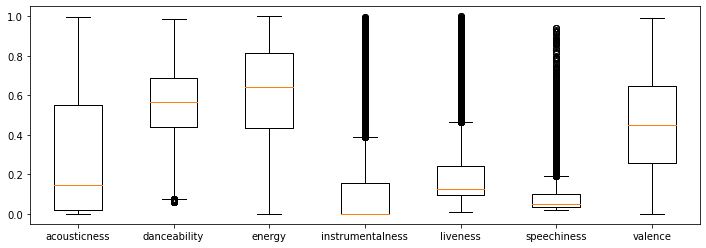

In [38]:
cols = mean_filled[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']]
plt.figure(figsize=(12,4))
plt.boxplot([cols[column] for column in cols.columns],
labels= [column for column in cols.columns])
plt.show()

In [39]:
# Normalize the data
scaler = MinMaxScaler()

dropped[numeric_columns] = scaler.fit_transform(dropped[numeric_columns])

dropped.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000
mean,0.447239,0.305974,0.558418,0.051306,0.600330,0.181603,0.193820,0.746596,0.093738,0.460001,0.456921
std,0.157026,0.341108,0.178652,0.024567,0.264501,0.325710,0.161501,0.121179,0.101502,0.164865,0.246942
min,0.000000,0.000000,0.059600,0.000000,0.000792,0.000000,0.009670,0.000000,0.022300,0.000000,0.000000
25%,0.343434,0.020000,0.442000,0.039034,0.433000,0.000000,0.097000,0.712798,0.036100,0.325640,0.259000
50%,0.454545,0.144000,0.569000,0.047301,0.644000,0.000157,0.126000,0.783008,0.048900,0.459361,0.449000
75%,0.565657,0.550000,0.687000,0.058060,0.817000,0.152000,0.244000,0.824414,0.098800,0.570094,0.648000
max,1.000000,0.996000,0.986000,1.000000,0.999000,0.996000,1.000000,1.000000,0.942000,1.000000,0.992000


In [40]:
mean_filled.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,44.220420,0.306383,0.558241,44.220420,0.599755,0.181601,0.193896,44.220420,0.093586,44.220420,0.456264
std,15.542008,0.341340,0.178632,15.542008,0.264559,0.325409,0.161637,15.542008,0.101373,15.542008,0.247119
min,0.000000,0.000000,0.059600,0.000000,0.000792,0.000000,0.009670,0.000000,0.022300,0.000000,0.000000
25%,34.000000,0.020000,0.442000,34.000000,0.433000,0.000000,0.096900,34.000000,0.036100,34.000000,0.257000
50%,45.000000,0.144000,0.568000,45.000000,0.643000,0.000158,0.126000,45.000000,0.048900,45.000000,0.448000
75%,56.000000,0.552000,0.687000,56.000000,0.815000,0.155000,0.244000,56.000000,0.098525,56.000000,0.648000
max,99.000000,0.996000,0.986000,99.000000,0.999000,0.996000,1.000000,99.000000,0.942000,99.000000,0.992000


In [41]:
# Normalize the data
scaler = MinMaxScaler()

mean_filled[numeric_columns] = scaler.fit_transform(
    mean_filled[numeric_columns])

mean_filled.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.446671,0.306383,0.558241,0.446671,0.599755,0.181601,0.193896,0.446671,0.093586,0.446671,0.456264
std,0.156990,0.341340,0.178632,0.156990,0.264559,0.325409,0.161637,0.156990,0.101373,0.156990,0.247119
min,0.000000,0.000000,0.059600,0.000000,0.000792,0.000000,0.009670,0.000000,0.022300,0.000000,0.000000
25%,0.343434,0.020000,0.442000,0.343434,0.433000,0.000000,0.096900,0.343434,0.036100,0.343434,0.257000
50%,0.454545,0.144000,0.568000,0.454545,0.643000,0.000158,0.126000,0.454545,0.048900,0.454545,0.448000
75%,0.565657,0.552000,0.687000,0.565657,0.815000,0.155000,0.244000,0.565657,0.098525,0.565657,0.648000
max,1.000000,0.996000,0.986000,1.000000,0.999000,0.996000,1.000000,1.000000,0.942000,1.000000,0.992000


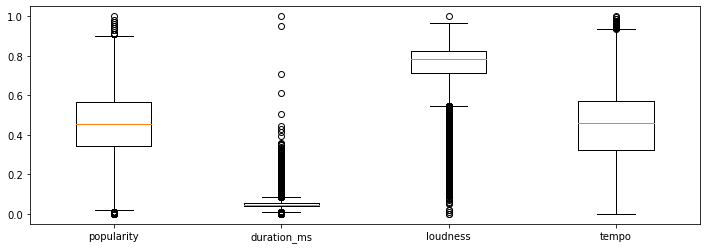

In [42]:
cols = dropped[numeric_columns]
plt.figure(figsize=(12,4))
plt.boxplot([cols[column] for column in cols.columns],
labels= [column for column in cols.columns])
plt.show()

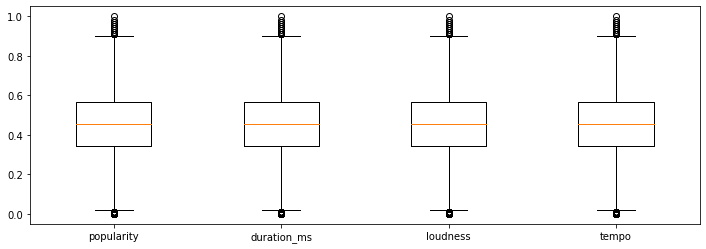

In [43]:
cols = mean_filled[numeric_columns]
plt.figure(figsize=(12,4))
plt.boxplot([cols[column] for column in cols.columns],
labels= [column for column in cols.columns])
plt.show()

In [44]:
gs = dropped.music_genre.unique()
numeric = dropped.columns.drop(['instance_id', 'artist_name', 'track_name', 'key', 'mode', 'music_genre'])
colors = sns.color_palette('cool',10)
nrows = 3
ncols = 4
fig, axs = plt.subplots(ncols,nrows, figsize = (25,25))
i = 0
for col in numeric:
    idx = (int(i/nrows), i%nrows)
    min = dropped[col].min()
    max = dropped[col].max()
    diff = max-min
    binw = [x*diff/20+min for x in range(20)]
    img = [axs[idx].hist(x=dropped[dropped['music_genre'] == gs[i]][col], bins=binw, alpha=0.5, histtype='bar', color = colors[i])
     for i in range(len(gs))]
    axs[idx].set(title = col)
    i += 1
fig.delaxes(axs[(int(i/nrows), i%nrows)])
fig.legend(labels=[dropped[dropped['music_genre'] == gs[i]]['music_genre'].iloc[0] for i in range(len(gs))], ncol=3, loc = 8, fontsize = 'medium', frameon=True, borderaxespad=0.5)
fig.suptitle('Histograms for each numerical attribute',size='xx-large')
plt.show()

KeyError: "['instance_id'] not found in axis"

[Text(0.5, 0, 'popularity'),
 Text(1.5, 0, 'acousticness'),
 Text(2.5, 0, 'danceability'),
 Text(3.5, 0, 'duration_ms'),
 Text(4.5, 0, 'energy'),
 Text(5.5, 0, 'instrumentalness'),
 Text(6.5, 0, 'liveness'),
 Text(7.5, 0, 'loudness'),
 Text(8.5, 0, 'speechiness'),
 Text(9.5, 0, 'tempo'),
 Text(10.5, 0, 'valence')]

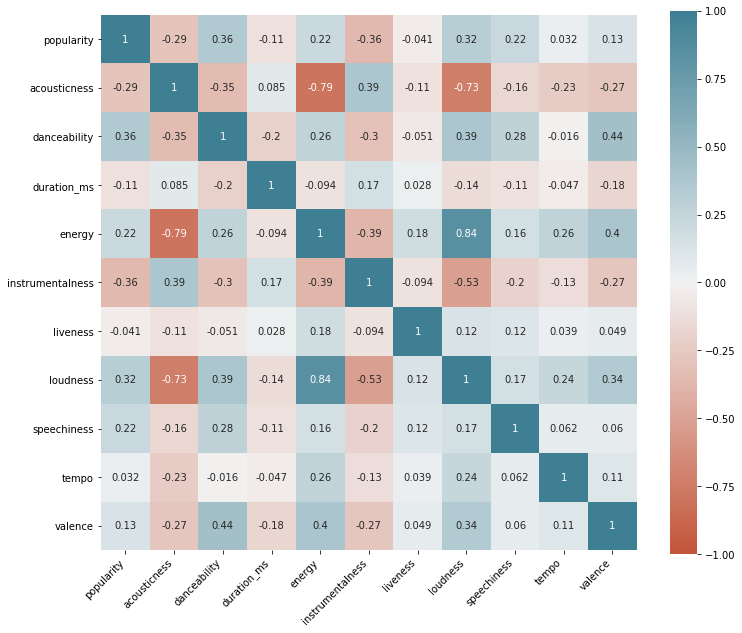

In [ ]:
np.random.seed(1)

# Compute the correlation matrix
corr = dropped.drop(columns=['instance_id']).corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12,10))

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)


In [ ]:
cs = df.columns.drop(['artist_name',
                      'track_name', 'key', 'mode', 'music_genre'])
corrs = {}
for c in cs:
    F, p = stats.f_oneway(dropped[dropped.music_genre == gs[0]][c],
                          dropped[dropped.music_genre == gs[1]][c],
                          dropped[dropped.music_genre == gs[2]][c],
                          dropped[dropped.music_genre == gs[3]][c],
                          dropped[dropped.music_genre == gs[4]][c],
                          dropped[dropped.music_genre == gs[5]][c],
                          dropped[dropped.music_genre == gs[6]][c],
                          dropped[dropped.music_genre == gs[7]][c],
                          dropped[dropped.music_genre == gs[8]][c],
                          dropped[dropped.music_genre == gs[9]][c])
    corrs[c] = F

# The greater the F score value the higher the correlation will be.
sorted_corrs = dict(
    sorted(corrs.items(), key=lambda item: item[1], reverse=True))

print('Correlation with genre:')
for key, val in sorted_corrs.items():
    print(key, val)


Correlation with genre:
popularity 7388.910774000588
loudness 4555.559315438988
acousticness 2888.6088401772586
danceability 2756.5654069084253
instrumentalness 2443.8024597525455
energy 2430.8342230958933
speechiness 1780.0020558634358
valence 815.9490530984743
duration_ms 310.6960785680012
tempo 219.47072272122085
liveness 61.02393059611778


In [ ]:
# Create a csv file containing the preprocessed data
dropped.to_csv('../input/dropped.csv', index = False)
mean_filled.to_csv('../input/mean_filled.csv', index=False)
